In [1]:
# Standard imports

from g4beam import *
from scan import *

import math
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
from tqdm import *
import pickle
import itertools
from tabulate import tabulate

# Beta, 110 microns

In [2]:
# Ranges to scan
angles = np.linspace(40, 60, 20)
lengths = [6, 7, 8]
betas = [0.024, 0.027, 0.03, 0.033]
# Constants
alpha = 0.7
momentum = 100
pz_std = 0.8
t_emit = 0.110
l_emit = 1

In [29]:
def fun(angle, length, beta):
    before = gen_distribution((beta, alpha, t_emit, 0, 0), (beta, alpha, t_emit, 0, 0), momentum, pz_std, z_emit=l_emit)
    after = run_distribution(before, length, angle, 24)
    return after

results = run_scan(fun, (angles, lengths, betas), "results/angle_length_beta_repeated.pkl", trials=12)

100%|████████████████████████████████████████████████████████████████████████████| 2880/2880 [5:20:57<00:00,  6.69s/it]


## Emittances

In [3]:
with open("results/angle_length_beta_repeated.pkl", "rb") as file:
    results = pickle.load(file)

emittance_results_1 = qmaps_to_dataframe((
                        calc_quantity(lambda df: emittances(cut_outliers(df))[0], results),
                        calc_quantity(lambda df: emittances(cut_outliers(df))[1], results),
                        calc_quantity(lambda df: emittances(cut_outliers(df))[2], results)
                    ), ["angle", "length", "beta"], ["xemit", "yemit", "zemit"])

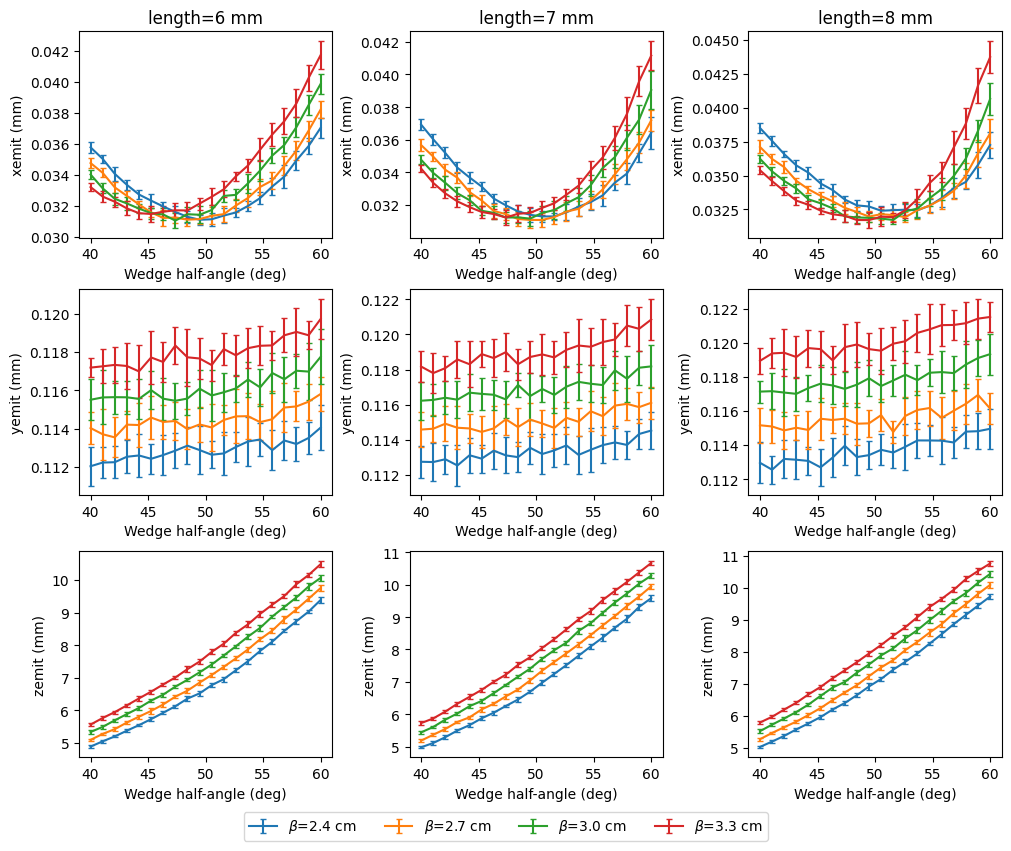

In [4]:
# Graph results
fig, axs = plt.subplots(nrows = 3, ncols = len(lengths), layout="constrained")
fig.set_size_inches(10, 8)
artists = [None]*len(betas)
for i, w in enumerate(lengths):
    for k, beta in enumerate(betas):
        subresult = emittance_results_1[(emittance_results_1["length"] == w) & (emittance_results_1["beta"] == beta)]
        for j, x in enumerate(["xemit", "yemit", "zemit"]):
            ax = axs[j][i]
            artists[k] = ax.errorbar(subresult["angle"], subresult[x], yerr = subresult[x+"_std"], label=f"$\\beta$={beta*100:.1f} cm", capsize=2)
            ax.set_ylabel(x + " (mm)")
            ax.set_xlabel("Wedge half-angle (deg)")
    # axs[0][i].axhline(t_emit, color='gray', linestyle="--")
    # axs[0][i].axhline(0.03, color='tab:cyan', linestyle="--")
    # axs[1][i].axhline(t_emit, color='gray', linestyle="--")
    # axs[2][i].axhline(l_emit, color='gray', linestyle="--")
    axs[0][i].set_title(f"length={w} mm")
fig.legend(handles=artists, ncols=len(betas), loc="upper center", bbox_to_anchor=(0.5, 0))
# fig.suptitle(f"Effect of beta on emittances\nalpha={alpha}, momentum={momentum} MeV/c, sigma-pz={pz_std} MeV/c, transverse emittance {t_emit} mm, longitudinal emittance {l_emit} mm")

In [14]:
# Table of minimums

minima = [emittance_results_1[emittance_results_1["beta"] == beta]["xemit"].idxmin() for beta in betas]
minima_df = emittance_results_1.iloc[minima].set_index("beta", drop=False)
minima_df["xemit"] *= 1000
minima_df["yemit"] *= 1000
minima_df["xemit_std"] *= 1000
minima_df["yemit_std"] *= 1000
minima_df
# plt.errorbar(minima_df["beta"], minima_df["zemit"], yerr=minima_df["zemit_std"])

,angle,length,beta,xemit,yemit,zemit,xemit_std,yemit_std,zemit_std
beta,,,,,,,,,
0.024,49.473684,6,0.024,31.100139,112.884955,6.522014,0.330850,1.240570,0.079941
0.027,50.526316,7,0.027,31.089168,114.931629,7.345871,0.438901,0.772964,0.084855
0.030,47.368421,6,0.030,31.042450,115.458286,6.728267,0.487751,0.934364,0.051487
0.033,47.368421,7,0.033,31.237616,118.993240,7.221185,0.481505,1.084265,0.069627


In [20]:
print(tabulate(
    minima_df[["xemit", "yemit", "zemit", "angle", "length"]],
    # headers=[r"$\beta$ (m)", r"$\epsilon_x$ (mm)", r"$\epsilon_y$ (mm)", r"$\epsilon_z$ (mm)", r"Half-angle (deg)", r"Length (mm)"],
    tablefmt="latex_raw",
    floatfmt=["", ".2f", ".1f", ".3f"]
))

\begin{tabular}{rrrrrr}
\hline
 0.024 & 31.10 & 112.9 & 6.522 & 49.4737 & 6 \\
 0.027 & 31.09 & 114.9 & 7.346 & 50.5263 & 7 \\
 0.03  & 31.04 & 115.5 & 6.728 & 47.3684 & 6 \\
 0.033 & 31.24 & 119.0 & 7.221 & 47.3684 & 7 \\
\hline
\end{tabular}


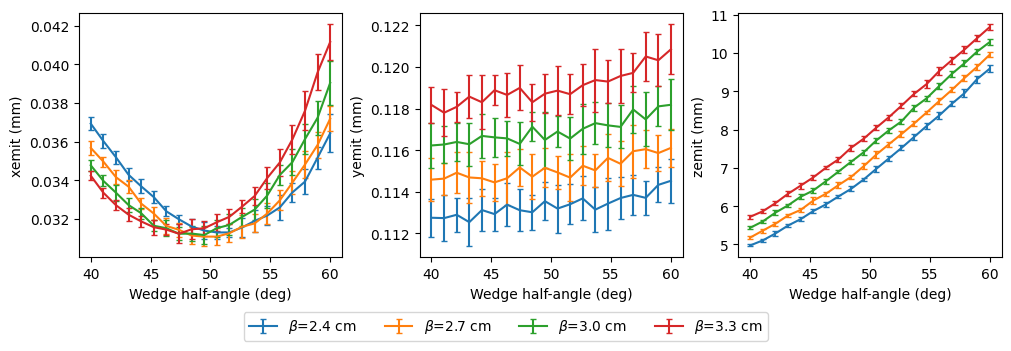

In [9]:
# Version I show in powerpoint
fig, axs = plt.subplots(nrows = 1, ncols = 3, layout="constrained")
fig.set_size_inches(10, 3)
artists = [None]*len(betas)
w = lengths[1]
for k, beta in enumerate(betas):
    subresult = emittance_results_1[(emittance_results_1["length"] == w) & (emittance_results_1["beta"] == beta)]
    for j, x in enumerate(["xemit", "yemit", "zemit"]):
        ax = axs[j]
        artists[k] = ax.errorbar(subresult["angle"], subresult[x], yerr = subresult[x+"_std"], label=f"$\\beta$={beta*100:.1f} cm", capsize=2)
        ax.set_ylabel(x + " (mm)")
        ax.set_xlabel("Wedge half-angle (deg)")
fig.legend(handles=artists, ncols=len(betas), loc="upper center", bbox_to_anchor=(0.5, 0))

## Sigma-p

In [23]:
with open("results/angle_length_beta_repeated.pkl", "rb") as file:
    results = pickle.load(file)

sigma_p_results = qmap_to_dataframe(calc_quantity(lambda df: np.std(p_total(cut_outliers(df))), results), ["angle", "length", "beta"], "sigma_p")

In [4]:
sigma_p_results

,angle,length,beta,sigma_p,sigma_p_std
0,40.0,6,0.024,4.219554,0.029540
1,40.0,6,0.027,4.441252,0.022562
2,40.0,6,0.030,4.668142,0.037026
3,40.0,6,0.033,4.891079,0.017318
4,40.0,7,0.024,4.411626,0.021581
...,...,...,...,...,...
235,60.0,7,0.033,9.876511,0.055536
236,60.0,8,0.024,9.155675,0.059223
237,60.0,8,0.027,9.511954,0.057080
238,60.0,8,0.030,9.889254,0.065594


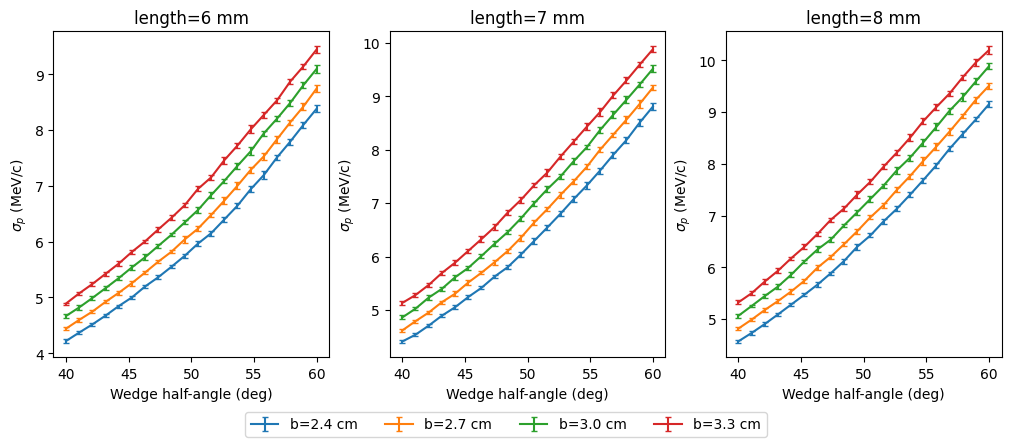

In [25]:
# Graph results
fig, axs = plt.subplots(ncols = len(lengths), layout="constrained")
fig.set_size_inches(10, 4)
artists = [None]*len(betas)
for i, w in enumerate(lengths):
    ax = axs[i]
    for k, beta in enumerate(betas):
        subresult = sigma_p_results[(sigma_p_results["length"] == w) & (sigma_p_results["beta"] == beta)]
        artists[k] = ax.errorbar(subresult["angle"], subresult["sigma_p"], yerr = subresult["sigma_p_std"], label=f"b={beta*100:.1f} cm", capsize=2)
        ax.set_ylabel(r"$\sigma_p$ (MeV/c)")
        ax.set_xlabel("Wedge half-angle (deg)")
    ax.set_title(f"length={w} mm")

fig.legend(handles=artists, ncols=len(betas), loc="upper center", bbox_to_anchor=(0.5, 0))
# fig.suptitle(f"Effect of beta on p-sigma\nalpha={alpha}, momentum={momentum} MeV/c, sigma-pz={pz_std} MeV/c, transverse emittance {t_emit} mm, longitudinal emittance {l_emit} mm")

# Alpha, 110 microns

In [6]:
# Ranges to scan
angles = np.linspace(40, 60, 20)
lengths = [6, 7, 8]
alphas = [0.5, 0.7, 0.9, 1.1]
# Constants
beta = 0.027
momentum = 100
pz_std = 0.8
t_emit = 0.110
l_emit = 1

In [10]:
def fun(angle, length, alpha):
    before = gen_distribution((beta, alpha, t_emit, 0, 0), (beta, alpha, t_emit, 0, 0), momentum, pz_std, z_emit=l_emit)
    after = run_distribution(before, length, angle, 24)
    return after

results = run_scan(fun, (angles, lengths, alphas), "results/angle_length_alpha_repeated.pkl", trials=12)

100%|████████████████████████████████████████████████████████████████████████████| 2880/2880 [5:31:47<00:00,  6.91s/it]


In [7]:
with open("results/angle_length_alpha_repeated.pkl", "rb") as file:
    results = pickle.load(file)

emittance_results = qmaps_to_dataframe((
                        calc_quantity(lambda df: emittances(cut_outliers(df))[0], results),
                        calc_quantity(lambda df: emittances(cut_outliers(df))[1], results),
                        calc_quantity(lambda df: emittances(cut_outliers(df))[2], results)
                    ), ["angle", "length", "alpha"], ["xemit", "yemit", "zemit"])

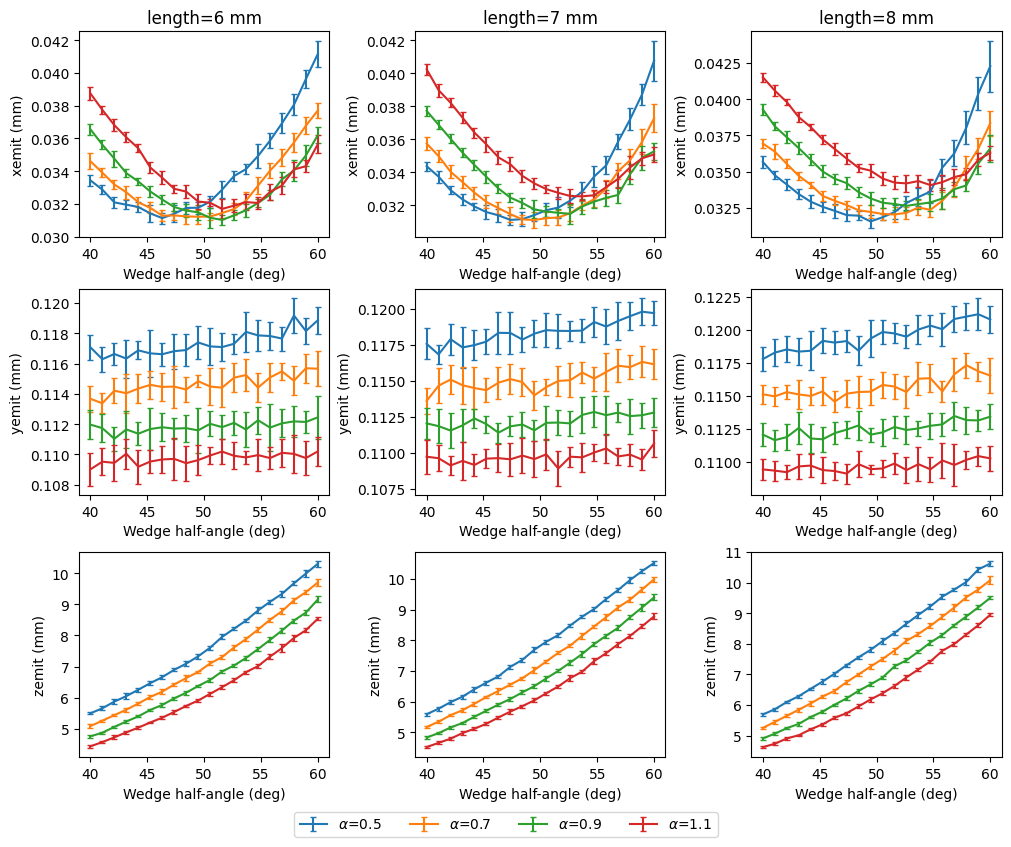

In [48]:
# Graph results
fig, axs = plt.subplots(nrows = 3, ncols = len(lengths), layout="constrained")
fig.set_size_inches(10, 8)
artists = [None] * len(alphas)
for i, w in enumerate(lengths):
    for k, alpha in enumerate(alphas):
        subresult = emittance_results[(emittance_results["length"] == w) & (emittance_results["alpha"] == alpha)]
        for j, x in enumerate(["xemit", "yemit", "zemit"]):
            ax = axs[j][i]
            artists[k] = ax.errorbar(subresult["angle"], subresult[x], yerr = subresult[x+"_std"], label=f"$\\alpha$={alpha}", capsize=2)
            ax.set_ylabel(x + " (mm)")
            ax.set_xlabel("Wedge half-angle (deg)")
    # axs[0][i].axhline(t_emit, color='gray', linestyle="--")
    # axs[0][i].axhline(0.03, color='tab:cyan', linestyle="--")
    # axs[1][i].axhline(t_emit, color='gray', linestyle="--")
    # axs[2][i].axhline(l_emit, color='gray', linestyle="--")
    axs[0][i].set_title(f"length={w} mm")
fig.legend(handles=artists, ncols=len(betas), loc="upper center", bbox_to_anchor=(0.5, 0))
# fig.suptitle(f"Effect of alpha on emittances\nbeta={beta} m, momentum={momentum} MeV/c, sigma-pz={pz_std} MeV/c, transverse emittance {t_emit} mm, longitudinal emittance {l_emit} mm")

In [21]:
# Table of minimums

minima = [emittance_results[emittance_results["alpha"] == alpha]["xemit"].idxmin() for alpha in alphas]
minima_df = emittance_results.iloc[minima].set_index("alpha", drop=False)
minima_df["xemit"] *= 1000
minima_df["yemit"] *= 1000
minima_df["xemit_std"] *= 1000
minima_df["yemit_std"] *= 1000
minima_df
# plt.errorbar(minima_df["beta"], minima_df["zemit"], yerr=minima_df["zemit_std"])

,angle,length,alpha,xemit,yemit,zemit,xemit_std,yemit_std,zemit_std
alpha,,,,,,,,,
0.5,47.368421,7,0.5,31.111485,118.337942,7.135160,0.298932,1.439302,0.057585
0.7,49.473684,7,0.7,31.104148,113.999974,7.026822,0.484164,0.985050,0.108014
0.9,51.578947,6,0.9,31.032800,111.803390,6.842975,0.309055,0.776502,0.048048
1.1,51.578947,6,1.1,31.701465,110.193488,6.337572,0.601379,0.821857,0.059719


In [22]:
print(tabulate(
    minima_df[["xemit", "yemit", "zemit", "angle", "length"]],
    # headers=[r"$\beta$ (m)", r"$\epsilon_x$ (mm)", r"$\epsilon_y$ (mm)", r"$\epsilon_z$ (mm)", r"Half-angle (deg)", r"Length (mm)"],
    tablefmt="latex_raw",
    floatfmt=["", ".2f", ".1f", ".3f"]
))

\begin{tabular}{rrrrrr}
\hline
 0.5 & 31.11 & 118.3 & 7.135 & 47.3684 & 7 \\
 0.7 & 31.10 & 114.0 & 7.027 & 49.4737 & 7 \\
 0.9 & 31.03 & 111.8 & 6.843 & 51.5789 & 6 \\
 1.1 & 31.70 & 110.2 & 6.338 & 51.5789 & 6 \\
\hline
\end{tabular}


In [14]:
with open("results/angle_length_alpha_repeated.pkl", "rb") as file:
    results = pickle.load(file)

sigma_p_results = qmap_to_dataframe(calc_quantity(lambda df: np.std(p_total(cut_outliers(df))), results), ["angle", "length", "alpha"], "sigma_p")

Text(0.5, 0.98, 'Effect of alpha on p-sigma\nbeta=0.027, momentum=100 MeV/c, sigma-pz=0.8 MeV/c, transverse emittance 0.11 mm, longitudinal emittance 1 mm')

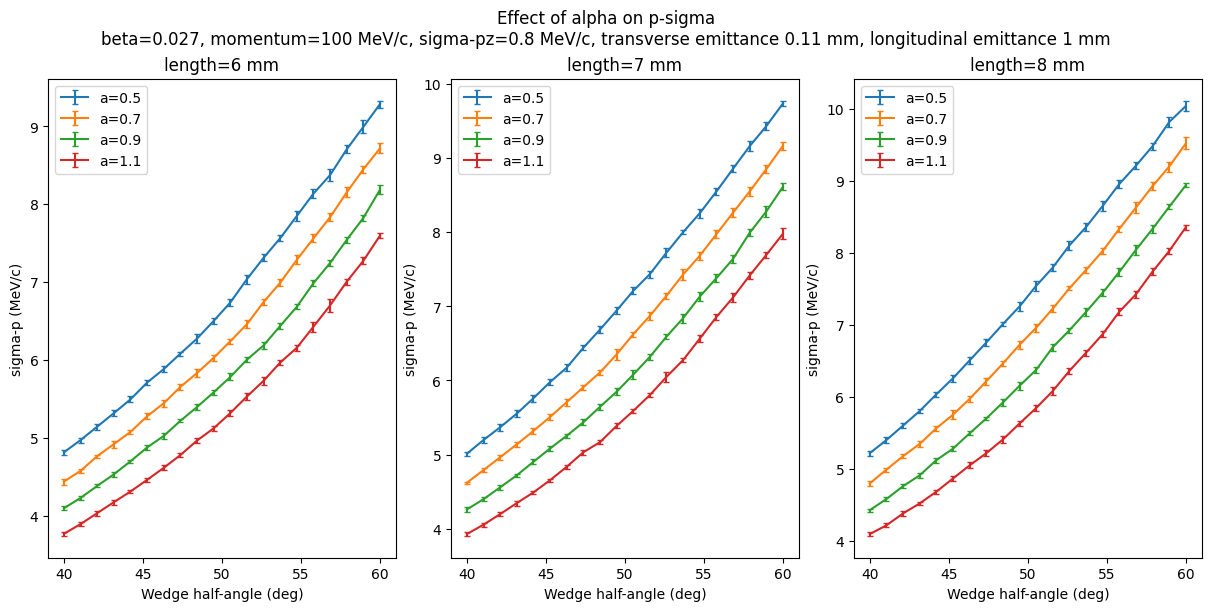

In [17]:
# Graph results
fig, axs = plt.subplots(ncols = len(lengths), layout="constrained")
fig.set_size_inches(12, 6)
for i, w in enumerate(lengths):
    ax = axs[i]
    for alpha in alphas:
        subresult = sigma_p_results[(sigma_p_results["length"] == w) & (sigma_p_results["alpha"] == alpha)]
        ax.errorbar(subresult["angle"], subresult["sigma_p"], yerr = subresult["sigma_p_std"], label=f"a={alpha}", capsize=2)
        ax.set_ylabel("sigma-p (MeV/c)")
        ax.set_xlabel("Wedge half-angle (deg)")
    ax.legend()
    ax.set_title(f"length={w} mm")
fig.suptitle(f"Effect of alpha on p-sigma\nbeta={beta}, momentum={momentum} MeV/c, sigma-pz={pz_std} MeV/c, transverse emittance {t_emit} mm, longitudinal emittance {l_emit} mm")

# Momentum, 110 microns

In [12]:
# Ranges to scan
angles = np.linspace(40, 60, 20)
lengths = [5, 6, 7]
momentums = [100, 110, 120, 130]
# Constants
beta = 0.03
alpha = 1
pz_std = 0.8
t_emit = 0.110
l_emit = 1

In [50]:
def fun(angle, length, momentum):
    before = gen_distribution((beta, alpha, t_emit, 0, 0), (beta, alpha, t_emit, 0, 0), momentum, pz_std, z_emit=l_emit)
    after = run_distribution(before, length, angle, 24)
    return after

results = run_scan(fun, (angles, lengths, momentums), "results/angle_length_momentum_repeated.pkl", trials=12)

100%|████████████████████████████████████████████████████████████████████████████| 2880/2880 [4:45:30<00:00,  5.95s/it]


## Emittances

In [10]:
with open("results/angle_length_momentum_repeated.pkl", "rb") as file:
    results = pickle.load(file)

emittance_results_3 = qmaps_to_dataframe((
                        calc_quantity(lambda df: emittances(cut_outliers(df))[0], results),
                        calc_quantity(lambda df: emittances(cut_outliers(df))[1], results),
                        calc_quantity(lambda df: emittances(cut_outliers(df))[2], results)
                    ), ["angle", "length", "momentum"], ["xemit", "yemit", "zemit"])

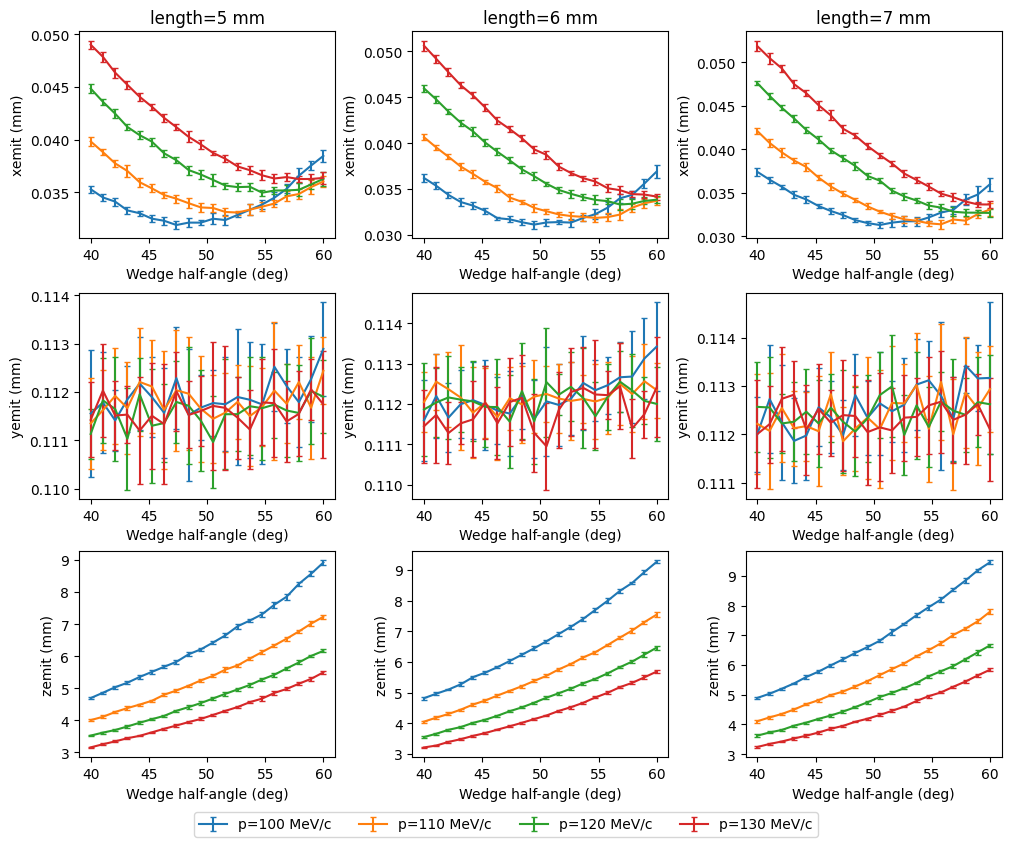

In [52]:
# Graph results
fig, axs = plt.subplots(nrows = 3, ncols = len(lengths), layout="constrained")
fig.set_size_inches(10, 8)
artists = [None]*len(betas)
for i, w in enumerate(lengths):
    for k, momentum in enumerate(momentums):
        subresult = emittance_results_3[(emittance_results_3["length"] == w) & (emittance_results_3["momentum"] == momentum)]
        for j, x in enumerate(["xemit", "yemit", "zemit"]):
            ax = axs[j][i]
            artists[k] = ax.errorbar(subresult["angle"], subresult[x], yerr = subresult[x+"_std"], label=f"p={momentum} MeV/c", capsize=2)
            ax.set_ylabel(x + " (mm)")
            ax.set_xlabel("Wedge half-angle (deg)")
    # axs[0][i].axhline(t_emit, color='gray', linestyle="--")
    # axs[0][i].axhline(0.03, color='tab:cyan', linestyle="--")
    # axs[1][i].axhline(t_emit, color='gray', linestyle="--")
    # axs[2][i].axhline(l_emit, color='gray', linestyle="--")
    axs[0][i].set_title(f"length={w} mm")
fig.legend(handles=artists, ncols=len(momentums), loc="upper center", bbox_to_anchor=(0.5, 0))
# fig.suptitle(f"Effect of beta on emittances\nalpha={alpha}, momentum={momentum} MeV/c, sigma-pz={pz_std} MeV/c, transverse emittance {t_emit} mm, longitudinal emittance {l_emit} mm")

In [18]:
axs[0][0].get_lines()

<a list of 12 Line2D objects>

In [9]:
# Table of minimums

minima = [emittance_results_1[emittance_results_1["beta"] == beta]["xemit"].idxmin() for beta in betas]
minima_df = emittance_results_1.iloc[minima].set_index("beta", drop=False)
minima_df
# plt.errorbar(minima_df["beta"], minima_df["zemit"], yerr=minima_df["zemit_std"])

,angle,length,beta,xemit,yemit,zemit,xemit_std,yemit_std,zemit_std
beta,,,,,,,,,
0.024,49.473684,6,0.024,0.031100,0.112885,6.522014,0.000331,0.001241,0.079941
0.027,50.526316,7,0.027,0.031089,0.114932,7.345871,0.000439,0.000773,0.084855
0.030,47.368421,6,0.030,0.031042,0.115458,6.728267,0.000488,0.000934,0.051487
0.033,47.368421,7,0.033,0.031238,0.118993,7.221185,0.000482,0.001084,0.069627


In [39]:
print(tabulate(
    minima_df[["beta", "xemit", "yemit", "zemit", "angle", "length"]],
    headers=[r"$\beta$ (m)", r"$\epsilon_x$ (mm)", r"$\epsilon_y$ (mm)", r"$\epsilon_z$ (mm)", r"Half-angle (deg)", r"Length (mm)"],
    tablefmt="latex_raw"
))

\begin{tabular}{rrrrrrr}
\hline
       &   $\beta$ (m) &   $\epsilon_x$ (mm) &   $\epsilon_y$ (mm) &   $\epsilon_z$ (mm) &   Half-angle (deg) &   Length (mm) \\
\hline
 0.024 &         0.024 &           0.0311001 &            0.112885 &             6.52201 &            49.4737 &             6 \\
 0.027 &         0.027 &           0.0310892 &            0.114932 &             7.34587 &            50.5263 &             7 \\
 0.03  &         0.03  &           0.0310425 &            0.115458 &             6.72827 &            47.3684 &             6 \\
 0.033 &         0.033 &           0.0312376 &            0.118993 &             7.22118 &            47.3684 &             7 \\
\hline
\end{tabular}


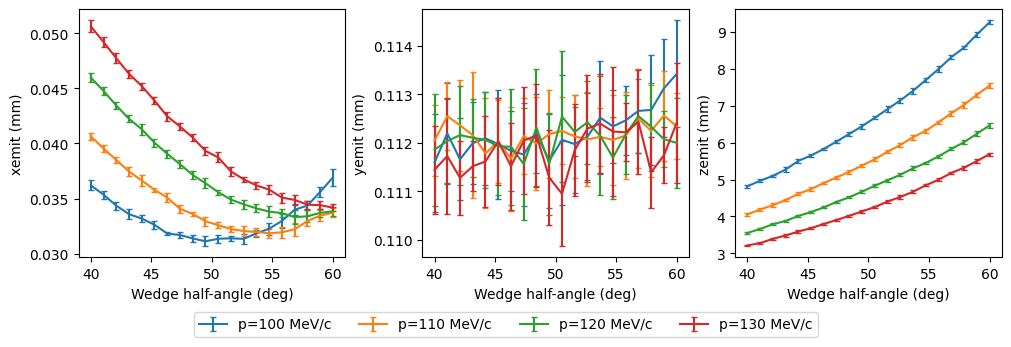

In [13]:
# Graph for powerpoint
fig, axs = plt.subplots(nrows = 1, ncols = 3, layout="constrained")
fig.set_size_inches(10, 3)
artists = [None]*len(betas)
w = lengths[1]
for k, momentum in enumerate(momentums):
    subresult = emittance_results_3[(emittance_results_3["length"] == w) & (emittance_results_3["momentum"] == momentum)]
    for j, x in enumerate(["xemit", "yemit", "zemit"]):
        ax = axs[j]
        artists[k] = ax.errorbar(subresult["angle"], subresult[x], yerr = subresult[x+"_std"], label=f"p={momentum} MeV/c", capsize=2)
        ax.set_ylabel(x + " (mm)")
        ax.set_xlabel("Wedge half-angle (deg)")
fig.legend(handles=artists, ncols=len(momentums), loc="upper center", bbox_to_anchor=(0.5, 0))